In [244]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import os
import sys
import subprocess
import pandas as pd
import seaborn as sb

import matplotlib.backends.backend_pdf
from datetime import datetime

#Fecha actual
ahora = str(datetime.now()).split(' ') 
fecha = ahora[0] 

print('Última modificacion: %s' %fecha)

lw=2
fz=15

Última modificacion: 2021-06-08


# Comparación entre el catálogo Variable Star Zoo con otros catálogos disponibles

El siguiente Jupyter notebook está destinado a explorar los catálogos que hasta el momento, tenemos disponibles para estudiar las fuentes variables dentro de la región establecida de antemano, por el proyecto Variable Star Zoo.

Para esto, hasta el momento hay 4 catálogos los cuales exploraremos sus propiedades, principalmente sus periodos estimados, y así veremos si son complementarios, contradictorios o algún caso intermedio. La idea es poner este notebook y los catálogos que se usen en un repositorio en Github, con el fin que pueda ser accedido y modificado por las personas que deseen colaborar en este proyecto. Además de ir avanzando con la correcta clasificación de las estrellas, usando como base fundamental la clasificación desde la plataforma Star Zoo.

Para comenzar, definiremos la función que siempre utilizo para escoger el bin óptimo en los histogramas, ya que los vamos a usar de base para tener una opinión sobre la distribución de periodos, además de sus comparaciones.

¡No se diga más!

In [5]:
#Función para obtener el número de bines optimos:
def nbins(X):
    """
    Taken from http://toyoizumilab.brain.riken.jp/hideaki/res/histogram.html
    """
    import numpy as np

    x_max = np.max(X)
    x_min = np.min(X)
    N_MIN = 5  #Minimum number of bins (integer)
               #N_MIN must be more than 1 (N_MIN > 1).
    N_MAX = 100  #Maximum number of bins (integer)
    N = range(N_MIN,N_MAX) # #of Bins
    N = np.array(N)
    D = (x_max-x_min)/N    #Bin size vector
    C = np.zeros((len(D),1))

    #Computation of the cost function
    for i in range(np.size(N)):
        edges = np.linspace(x_min,x_max,N[i]+1) # Bin edges
        ki = np.histogram(X,edges) # Count # of events in bins
        ki = ki[0]    
        k = np.mean(ki) #Mean of event count
        v = sum((ki-k)**2)/N[i] #Variance of event count
        C[i] = (2*k-v)/((D[i])**2) #The cost Function
    #Optimal Bin Size Selection
    cmin = min(C)
    idx  = np.where(C==cmin)
    
    #print idx

    try:
        idx = int(idx[0])
    except TypeError:
        idx = 10
        return 10
    
    optD = D[idx]

    edges = np.linspace(x_min,x_max,N[idx]+1)
    #plt.hist(X,edges, normed=True)
    #title(u"Histogram")
    #ylabel(u"Frequency")
    #xlabel(u"Value")
    return len(edges)-1


## Descripción de los datos

Daremos una breve descripción de cada uno de los catálogos usados en los siguientes plots, y que fueron combinados en TopCat usando una tolerancia espacial de 0.4 arcosegundos, la cual es la distancia usual que *personalmente uso* para hacer el crossmatch, dado que el tamaño de píxel del telescopio VISTA es de 0.34 arcsec.

Entonces, los catálogos que tenemos a continuación son:

1. periods_coord_IDs.csv: El cual es el archivo original con los IDs de las variables que fueron clasificadas, como también los periodos que poseen dada la clasificación, por lo que entiendo :)

2. OGLE_IV_BULGE_Modificado15Abril2021.txt: Catálogo completo del survey OGLE IV, el cual fue obtenido desde la página [del survey](http://ogledb.astrouw.edu.pl/~ogle/OCVS/catalog_query.php). Su catálogo posee más de 520 mil objetos, y muchos de ellos se distribuyen dentro de la región de interés. Además, sus principales características son la precisión de sus periodos, los cuales se han ido modificando y rectificando a lo largo de los años, y la clasificación del tipo de estrella, dado su periodo y serie de tiempo en la banda I.

3. VIVA_Ra_entre_259Y270_modificado.csv: Catálogo VIVA obtenido en una búsqueda SQL desde la página del VSA. El catálogo ha sido descargado entre las coordenadas 259 < Ra < 270, por lo que hay una región que no ha sido completamente cubierta. Hasta la fecha no lo he hecho dado que el catálogo pesa más de 4 Gigabites y mi internet no es de la mejor calidad. Sus principales atributos son los periodos calculados para todas las fuentes, el enrojecimiento, entre otros. Aún así, no todas las fuentes dentro del catálogo poseen un periodo complétamente fiable, de forma que hay muchos periodos "artifiales", que son menores a 0.1, y que físicamente se ven imposibilitados de existir, a menos que sean un sistema binario de periodo extraordinariamente pequeño. Es posible encontrar más información sobre este catálogo y sus columnas en el paper donde ha sido publicado:

4. CatalogoIncompleto_23Marzo2021.csv: El catálogo que he podido construir usando el periodograma para fuentes con periodos mayores a 2 días. El catálogo con los objetos con periodoso bajo 1 dia aún sigue en construcción

Con esto, haremos las comparaciones de periodos, de distribución y distribución espacial, y diferentes cosas dependiendo la información disponible en los catálogos (separando por clases cuando exista OGLE, por ejemplo).

Mi idea es adjuntar un archivo con los archivos que describiré a continuación. Los pondré en mi Dropbox mientras averiguo la mejor forma de subirlos a Github (aunque dudo que pueda subir el catálogo VIVA de casi 4GBs.)

Lo puedes descargar ACA, y lo que contiene es lo siguiente: 

In [370]:
ls ./Catalogos_locales/

CatalogoCompleto_23Marzo2021.cat
CatalogoCompleto_23Marzo2021.csv
OGLE_IV_BULGE.txt
OGLE_IV_BULGE_Modificado15Abril2021.txt
VIVA_Ra_entre_259Y270.xml
VIVA_Ra_entre_259Y270_modificado.csv
match_VIVA_OGLE.csv
match_VIVA_ZOO.csv
match_Zoo_OGLE.csv
periods_coord_IDs.csv


Empezaremos importando todos los archivos para poder tener un primer acercamiento visual de la región:

fuentes en Zoo: 55173
fuentes en OGLE: 520221
fuentes en VIVA: 16156703
fuentes en catalogo GLS: 5129


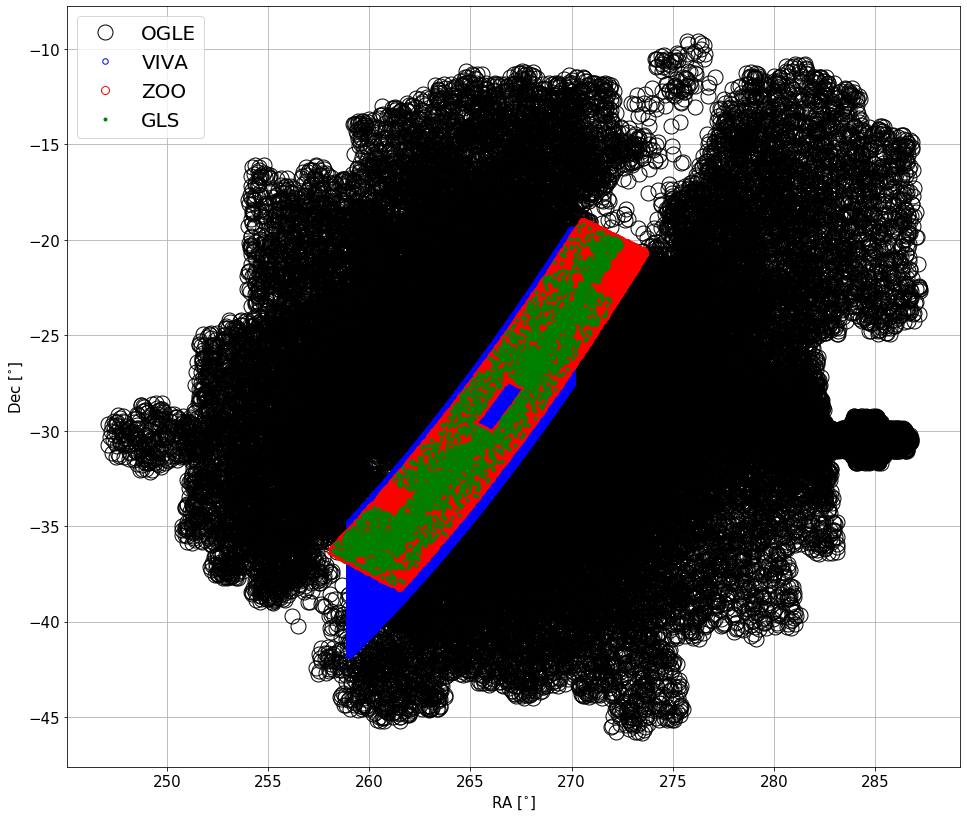

In [33]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_Zoo = pd.read_csv('./Catalogos_locales/periods_coord_IDs.csv', sep=',')
print("fuentes en Zoo:", len(df_Zoo['ID']))

df_OGLE = pd.read_csv('./Catalogos_locales/OGLE_IV_BULGE_Modificado15Abril2021.txt', sep=',',skiprows=0)
print("fuentes en OGLE:", len(df_OGLE['ID']))

df_VIVA = pd.read_csv('./Catalogos_locales/VIVA_Ra_entre_259Y270_modificado.csv', sep=',',skiprows=0)
print("fuentes en VIVA:", len(df_VIVA['ra']))

df_GLS = pd.read_csv('./Catalogos_locales/CatalogoCompleto_23Marzo2021.csv', sep=',',skiprows=0)
print("fuentes en catalogo GLS:", len(df_GLS['Ra']))

plt.figure(figsize=(16,14))

plt.plot(df_OGLE['Ra_degrees'], df_OGLE['Dec_Degrees'], 'ok', ms=15, mfc='none', label='OGLE')
plt.plot(df_VIVA['ra'],         df_VIVA['dec'], '.b', ms=11,mfc='none', label='VIVA')
plt.plot(df_Zoo['RA'],          df_Zoo['Dec'], 'or', ms=8, mfc='none', label='ZOO')
plt.plot(df_GLS['Ra'],          df_GLS['Dec'], '.g', ms=6, label='GLS')

plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

plt.xlabel('RA [$^{\circ}$]',fontsize=fz)
plt.ylabel('Dec [$^{\circ}$]',fontsize=fz)
plt.grid('on')

plt.show()

#plt.plot(df_OGLE['Ra_degrees'], df_OGLE['Dec_Degrees'], '.r')
#plt.show()

#_,_,_=plt.hist(df_OGLE['P_1'])
#plt.yscale('log')

Vale, tenemos el primer acercamiento al área de interés, que es la cubierta de rojo. Es evidente que gran parte del catálogo OGLE no servirán para nuestros propósitos; además de que los otros catálogos cubren, en diferentes proporciones, el área en cuestión. 

Veamos ahora la distribución de sus periodos:

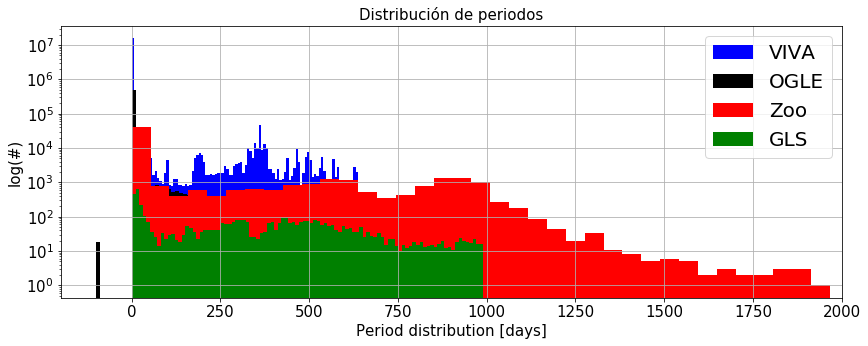

In [34]:
plt.figure(figsize=(14,5))
plt.title('Distribución de periodos', fontsize=fz)

_,_,_=plt.hist(df_VIVA['bestPeriod'], nbins(df_VIVA['bestPeriod']), color='blue', label='VIVA')
_,_,_=plt.hist(df_OGLE['P_1'], nbins(df_OGLE['P_1']), color='black', label='OGLE')
_,_,_=plt.hist(df_Zoo['period'], nbins(df_Zoo['period']), color='red', label='Zoo')
_,_,_=plt.hist(df_GLS['P'], nbins(df_GLS['P']), color='green', label='GLS')

plt.yscale('log')
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

plt.xlabel('Period distribution [days]',fontsize=fz)
plt.ylabel('log(#)',fontsize=fz)
plt.grid('on')
plt.xlim(-200, 2000)
plt.show()

Lo primero que llama mi atención es la cantidad de periodos que hay sobre 1000 días en el catálogo Variable Zoo. De hecho el catálogo posee unos periodos mayores a 5 mil días. Hay muy pocas estrellas reportadas con P > 1100 días y corresponde a fuentes RGB muy evolucionadas, con signos de que prontamente será una nebulosa planetaria dada su alta tasa de pérdida de masa. (iré poniendo referencias mientras vaya pasando por ellas)

Si se puede apreciar en la distribución de mi catálogo, hay un serio corte en P aprox 1000 días. Esta fue una condición física que pusimos al periodograma GLS, dado que el baseline de VVV es menor a 2000 días (entre 2010 y 2015). Para asegurar y comprobar periodicidad debe haber tiempo suficiente para que se cumpla por lo menos un ciclo. Muchos otros fenómenos estocásticos pueden ser confundidos por estrellas variables periodicas, como la variabilidad de Quasares o Objetos esteláres Jóvenes (YSOs)

Esto no quiere decir directamente que estos periodos están mal clasificados y/o determinadios, sino que, de alguna forma, encontrar este tipo de objetos variables con periodos altísimos es menos probable ya que están altamente contaminados por otros objetos. 

OGLE posee una gran cantidad de fuentes periodicas alrededor del cero, dada la cantidad de objetos binarios y RRlyraes que posee. Suena sensato. Por otro lado, VIVA también posee una clara sobrensidad alrededor de 0; creo que uno de las grandes contribuciones que hay aquí periodos artificiales bajo 0.1 días, también tiene periodos determinados con el valor "-99". 

## Comparaciones individuales de catálogos

Ahora iremos explorando los catalogos contrastado de forma que iremos comparando uno a uno los periodos en histogramas y también sobre los aliasings y estructuras que se pueden encontrar dentro de la comparación directa de los periodos desde catálogos diferentes.

Haremos diferentes análisis dada la información que nos ofrecen cada catálogo, principalmente comparando los diferentes periodos.

## 1. Zoo y OGLE

Partiremos primero comparando los catálogos ZOO-OGLE, teniendo en cuenta que OGLE posee clasificaciones de objetos bastante confiables. Al hacer crossmatch usando 0.4 arcsec de tolerancia, encontramos la nada despreciable suma de 9785 fuentes en común. Miraremos su distribución espacial separadas por tipos a continuación:

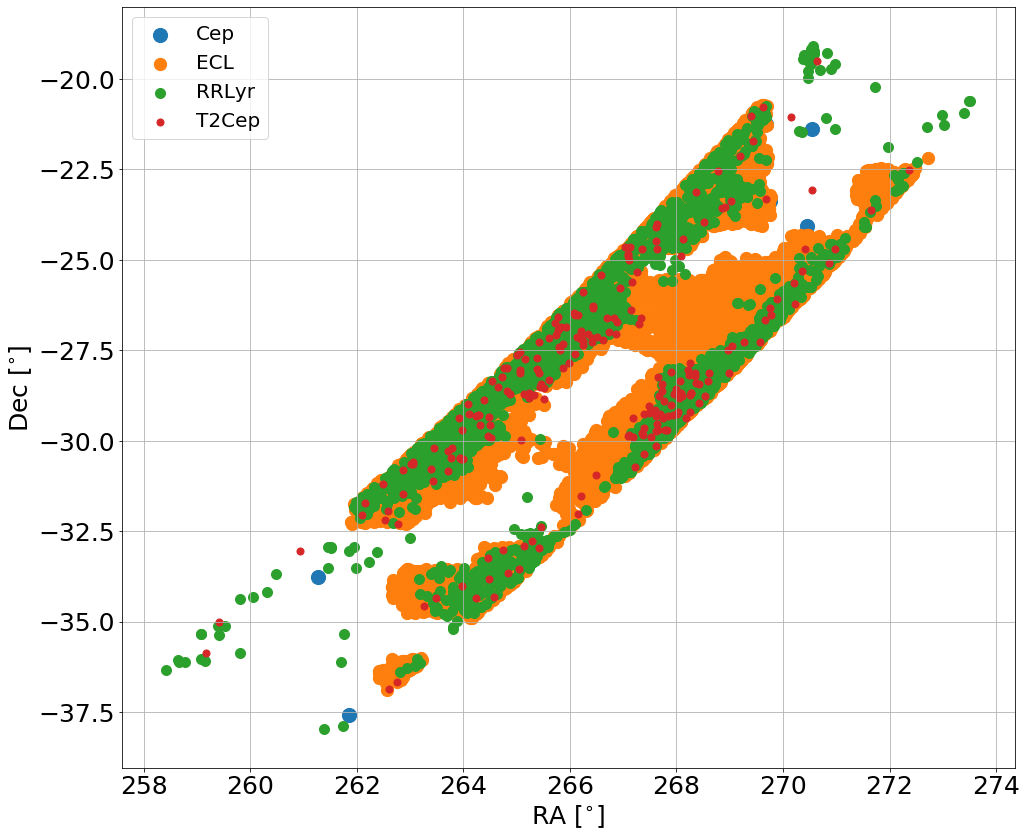

In [35]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_ZooOGLE = pd.read_csv('./Catalogos_locales/match_Zoo_OGLE.csv', sep=',',skiprows=0)

#Primero, visualizamos qué hay:
#Hacemos un array con los diferentes tipos de clasificacion
lista_clases = np.unique(df_ZooOGLE['Type'])
clases = df_ZooOGLE['Type']

#Ploteamos con colores diferentes por color y tamaño:
s=200
fz=25

fig, ax = plt.subplots(figsize=(16,14))
for grupos in lista_clases:
    clase = np.where(clases == grupos)
    for j in clase:  
        ax.scatter(df_ZooOGLE['RA_1'][j], df_ZooOGLE['Dec'][j], label = grupos, s=s)#, edgecolors='k', linewidths=0.5)
    s=s-50
ax.legend(loc='best', fontsize=20)

plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

plt.xlabel('RA [$^{\circ}$]',fontsize=fz)
plt.ylabel('Dec [$^{\circ}$]',fontsize=fz)
plt.grid('on')

plt.show()

Se ven estructuras bien demarcadas, hasta pareciera que hay fuentes ECL distribuidas en el centro galáctico :o

Ahora compararemos los periodos de ambos catálogos usando la clasificación (las clases) de OGLE. Para esto, haremos dos plots por cada clase, el primero será un histograma de la resta entre los periodos ($P_{zoo}$ - $P_{OGLE}$) con el fin de verificar qué tan lejos o en desacuerdo están estos periodos; y luego la comparación directa de periodos, donde serán usadas líneas con los aliasings más probables, con el doble del periodo 2p, y la mitad del periodo P/2. 

-----------------------------------------


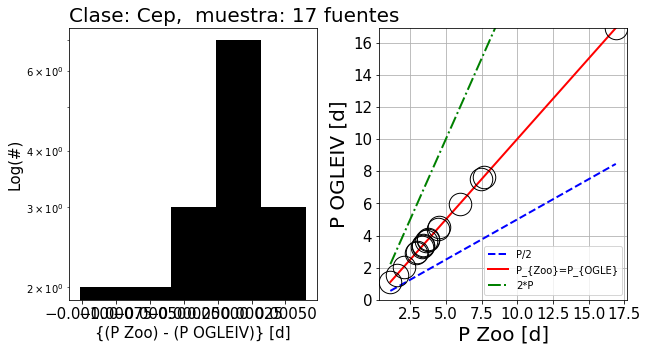

-----------------------------------------


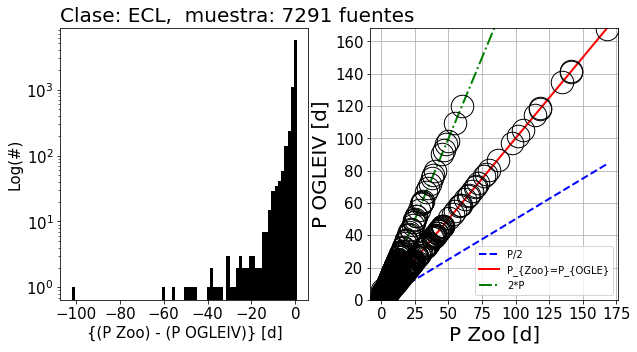

-----------------------------------------


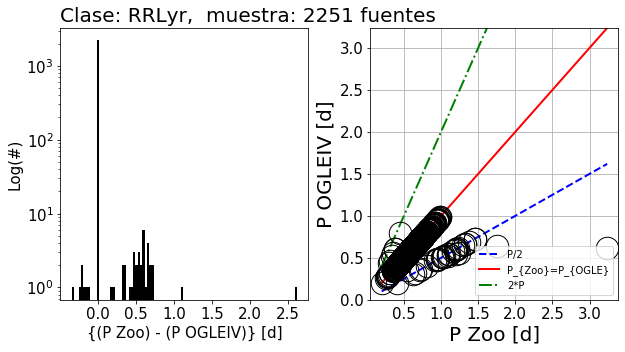

-----------------------------------------


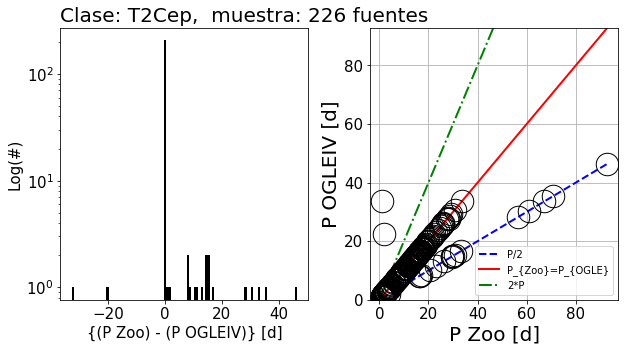

In [373]:
#df_ZooOGLE.hist(column='period', by='Type', bins=25, figsize=(14,4), color='#86bf91', rwidth=2)
#df_ZooOGLE.hist(column='P_1', by='Type', bins=25, figsize=(14,4), color='red', rwidth=2)
#plt.show()

#Hacemos un loop para cada clase:
for clase in lista_clases:

    #elegimos la clase de variable a visualizar:
    df = df_ZooOGLE[df_ZooOGLE['Type'] == clase ]
    
    print('-----------------------------------------------------------')
    plt.figure(figsize=(10,5))
    grid = plt.GridSpec(ncols=6, nrows=1, wspace=1.5, hspace=1.5)

    plt.subplot(grid[0,:3])
    plt.title('Clase: %s,  muestra: %i fuentes' %(clase,len(df['period'])),loc='left',fontsize=20)

    histograma = df['period']-df['P_1']
    _,_,_=plt.hist(histograma, bins=nbins(histograma), label=clase, color='k')
    plt.yscale('log')
    
    plt.xticks(fontsize=fz)
    plt.yticks(fontsize=fz)
    plt.xlabel('{(P Zoo) - (P OGLEIV)} [d]',fontsize=fz)
    plt.ylabel('Log(#)',fontsize=fz)

    plt.subplot(grid[0,3:])    
    xi = np.linspace(min(df['period']), max(df['period']), 100)    
    plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
    plt.plot(xi, xi, '-r', lw=lw, label='P_{Zoo}=P_{OGLE}')
    plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')
    plt.plot(df['period'], df['P_1'],'k.', ms=45, mfc='none')
    
    plt.xticks(fontsize=fz)
    plt.yticks(fontsize=fz)
    plt.xlabel('P Zoo [d]'  ,fontsize=fz+5)
    plt.ylabel('P OGLEIV [d]',fontsize=fz+5)
    plt.grid('on')
    
    plt.ylim(0,max(df['period']))
    plt.legend(loc='best', fontsize=10)
    plt.show()


- En el título de cada plot existe la información de la clase de objeto y el número de fuentes en común entre los catálogos estudiados. 

- Interesante ver que, en los paneles de la derecha, muy pocas fuentes poseen periodos localizados fuera de los lugares esperados. 

- A la izquierda, en el histograma de la comparación de periodos, he tenido que setear el eje y en logarítmico porque el número de fuentes lejos del cero era despreciable.

- Las lineas donde se produce el aliasing (múltiplos del periodo) serán los casos más probables de confusión, ya que aquí fallan en determinar periodos tanto los algoritmos espectrales de frecuencia como la clasificación humana, dado que las series de tiempo en el infrarrojo cercano no presentan las estructuras que las defines en las series de tiempo de la banda I; carecen de algunas de las características propias de sus clase. Los aliasings son completamente esperables.

- Para la clase RRLyr y tipo2 de cefeida, hay pequeñas distribuciones a la derecha del cero, lo que implica que la clasificación ciudadana tiene periodos el doble de largo. El otro caso es de la clase eclipsing binaries (ECL), que en su resta de periodos muestra una pequeña distribución a la izquierda del 0, por lo que una gran cantida de estrellas fueron clasificadas con el doble del periodo de OGLE. Entonces de aquí se desprende una forma rudimentaria para mirar los múltiplos de los periodos.

- De la clase Cefeidas ni hablar, los números decimales son necesita tantos ceros que no se entiende nada jajajaj.

Por lo tanto los plots de comparación arrojan que, en general, los periodos están de acuerdo en ambos catálogos

## 2. VIVA y OGLE

Ahora, seguimos con el mismo análisis y visualización usando el crossmatch entre el catálogo VIVA y el OGLE. Repetimos el mismo esquema, recordando que el catálogo debe ser descargando de nuevo usando criterios que contengan toda el área de interés.

número de fuentes en ambos catálogos: 24751


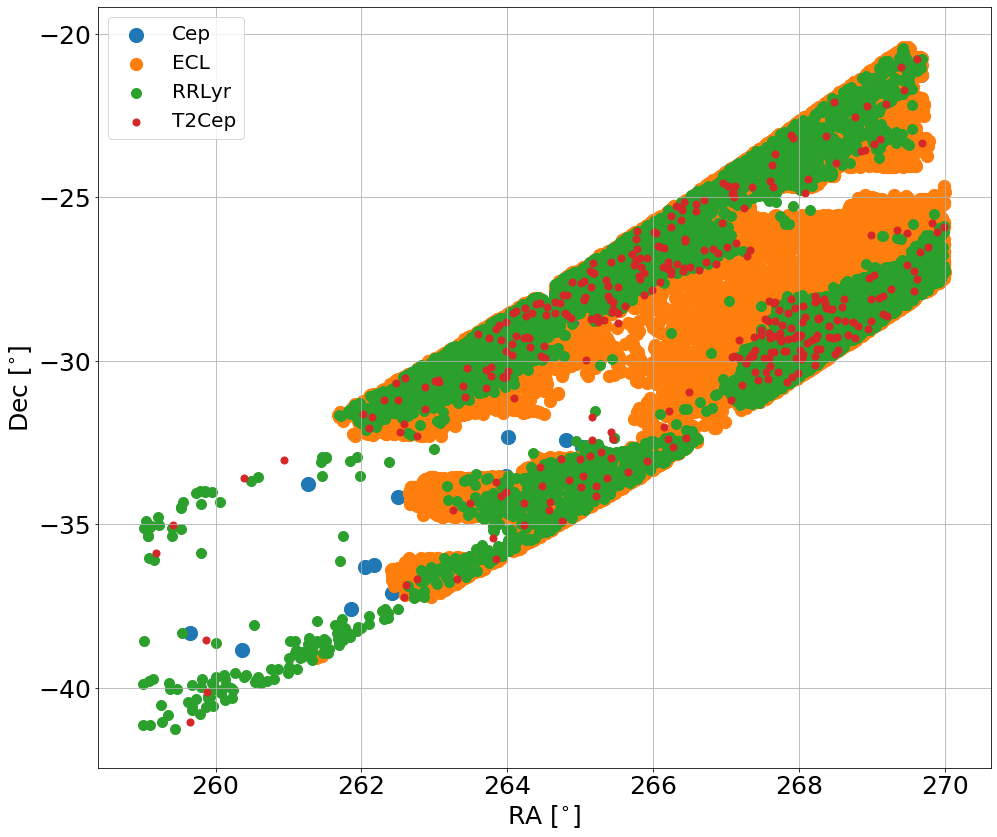

In [36]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_VIVAOGLE = pd.read_csv('./Catalogos_locales/match_VIVA_OGLE.csv', sep=',',skiprows=0)

print("número de fuentes en ambos catálogos:", len(df_VIVAOGLE['Type']) )
#Primero, visualizamos qué hay:

#Hacemos un array con los diferentes tipos de clasificacion
lista_clases = np.unique(df_VIVAOGLE['Type'])
clases = df_VIVAOGLE['Type']

#Ploteamos con colores diferentes por color y tamaño:
s=200
fz=25

fig, ax = plt.subplots(figsize=(16,14))
for grupos in lista_clases:
    clase = np.where(clases == grupos)
    for j in clase:  
        ax.scatter(df_VIVAOGLE['ra_1'][j], df_VIVAOGLE['dec'][j], label = grupos, s=s)#, edgecolors='k', linewidths=0.5)
    s=s-50
ax.legend(loc='best', fontsize=20)

plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

plt.xlabel('RA [$^{\circ}$]',fontsize=fz)
plt.ylabel('Dec [$^{\circ}$]',fontsize=fz)
plt.grid('on')

plt.show()

Demuestra una estructura similar a la que ya antes habíamos visto. Ahora proseguimos con la comparación de periodos:

-----------------------------------------


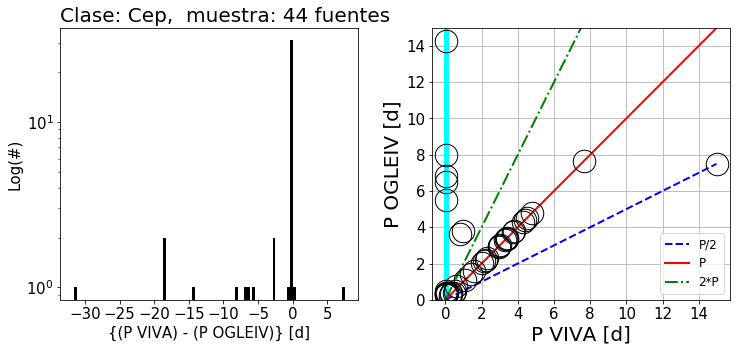

-----------------------------------------


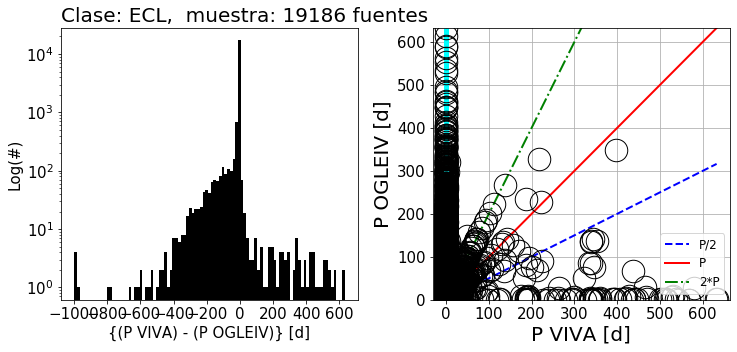

-----------------------------------------


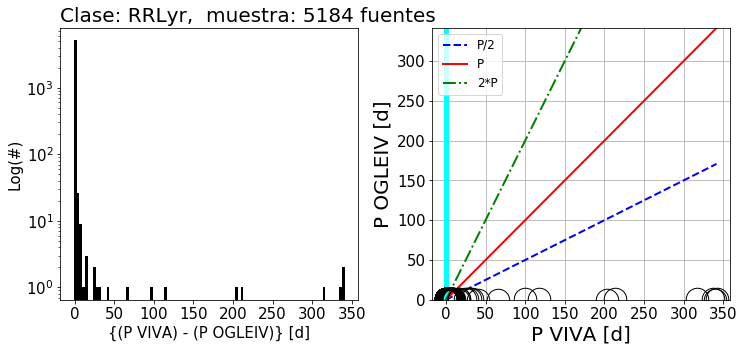

-----------------------------------------


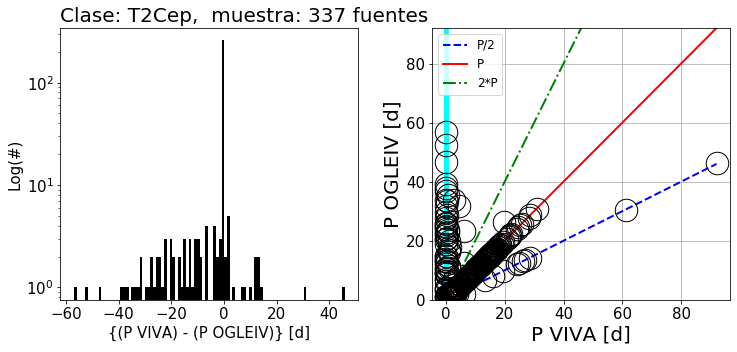

In [37]:
lw=2
fz=15

#Hacemos un loop para cada clasificación:
for clase in lista_clases:

    print('-----------------------------------------')
    plt.figure(figsize=(12,5))
    grid = plt.GridSpec(ncols=6, nrows=1, wspace=1.5, hspace=1.5)

    #elegimos la clase de variable a visualizar:
    df = df_VIVAOGLE[df_VIVAOGLE['Type'] == clase ]
    
    plt.subplot(grid[0,:3])
    plt.title('Clase: %s,  muestra: %i fuentes' %(clase,len(df['bestPeriod'])),loc='left',fontsize=20)
    
    histograma = df['bestPeriod']-df['P_1']
    _,_,_=plt.hist(histograma, bins=nbins(histograma), label=clase, color='k')
    plt.yscale('log')
    
    plt.xticks(fontsize=fz)
    plt.yticks(fontsize=fz)
    plt.xlabel('{(P VIVA) - (P OGLEIV)} [d]',fontsize=fz)
    plt.ylabel('Log(#)',fontsize=fz)

    
    plt.subplot(grid[0,3:])    
    xi = np.linspace(min(df['bestPeriod']), max(df['bestPeriod']), 100)    
    plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
    plt.plot(xi, xi, '-r', lw=lw, label='P')
    plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')
    plt.plot(df['bestPeriod'], df['P_1'],'k.', ms=45, mfc='none')
    
    plt.vlines(x=0.03, ymin=0, ymax=max(df['bestPeriod']), colors='cyan', linestyles='solid', lw=5)
    #plt.vlines(x=-99, ymin=0, ymax=max(df['bestPeriod']), colors='yellow', linestyles='--', lw=5)
    
    plt.xticks(fontsize=fz)
    plt.yticks(fontsize=fz)
    plt.xlabel('P VIVA [d]'  ,fontsize=fz+5)
    plt.ylabel('P OGLEIV [d]',fontsize=fz+5)
    plt.grid('on')
    
    plt.ylim(0,max(df['bestPeriod']))
    plt.legend(loc='best', fontsize=12)
    plt.show()

- En la comparación de periodos, he agregado una línea vertical en el valor x=0.03, porque éste es el valor que el catálogo VIVA posee para muchas de las fuentes. No sé en realidad qué significa este valor, pero creo que está relacionado a que una fuente tiene probabilidad de ser periódica pero el periodo correcto no ha sido determinado, hay que ver bien el texto del paper, que lo dejo  [ACÁ](https://academic.oup.com/mnras/article-abstract/496/2/1730/5860297?redirectedFrom=fulltext)

- Las clase ECL posee 19186 fuentes en común con OGLE y posee muchas fuentes fuera de lugar. Por un lado, el histograma de comparación de periodos está muy centrado en el cero, lo que habla sobre que gran parte de las fuentes están de acuerdo y el plot está sesgado por sus rangos. También se ven muchos objetos a lo largo de la línea cyan. Y también muchos periodos muy largos (P>100) que están completamente en desacuerdo, y en ogle están alrededor del cero. Habría que mirar más en detalle para entender por completo el comportamiendo acá.

- Cepheidas ven un buen comportamiendo, parece que es fácil determinar su periodo :)

- RRLyrae es un tipo de variable muy abundante también, con 5184 objetos entre los catálogos. Como en el caso de las ECL también, dado los rangos del plot, entender bién el comportamiento cerca del cero, donde esperamos tener, sino, toda la muestra dada sus condiciones físicas. Igual, dado su histograma de comparación de periodos habla de contribución a la derecha del cero, por lo que espero que exista fuentes clasificadas en VIVA con periodos el doble de largos.

Ahora que conocemos un poco más sobre cómo podrían comportarse los datos, miremos el match entre el catálogo variable star zoo y VIVA, hechos con la misma base de datos.


## 3.- Star Zoo cataloge - VIVA

Recordando que el catálogo VIVA debe ser nuevamente obtenido para que cubra completamente la región de interés, es útil para ver la comparación entre los periodos, y muy ilustrador para mi, alguien que se ha dedicado a hacer lo mismo.

Veamos entonces qué nos depara todo esto. Ya no tenemos clases, iremos diréctamente al análisis de comparación de periodos.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


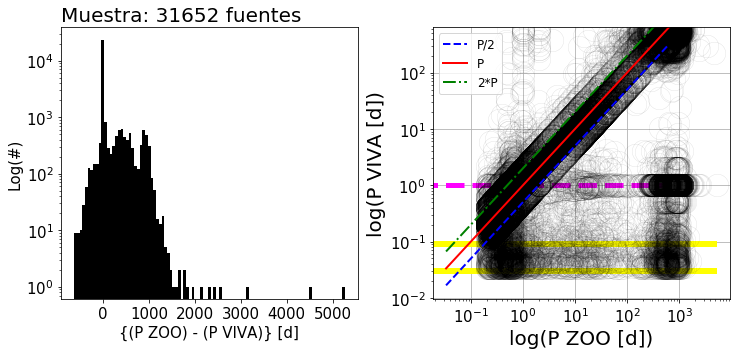

In [38]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_VIVAZOO = pd.read_csv('./Catalogos_locales/match_VIVA_ZOO.csv', sep=',',skiprows=0)

plt.figure(figsize=(12,5))
grid = plt.GridSpec(ncols=6, nrows=1, wspace=1.5, hspace=1.5)
    
plt.subplot(grid[0,:3])

plt.title('Muestra: %i fuentes' %len(df_VIVAZOO['period']),loc='left',fontsize=20)
    
histograma = df_VIVAZOO['period']-df_VIVAZOO['bestPeriod']
_,_,_=plt.hist(histograma, bins=nbins(histograma), color='k')
plt.yscale('log')
    
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)
plt.xlabel('{(P ZOO) - (P VIVA)} [d]',fontsize=fz)
plt.ylabel('Log(#)',fontsize=fz)
 
plt.subplot(grid[0,3:])    

plt.plot(df_VIVAZOO['period'], df_VIVAZOO['bestPeriod'],'k.', ms=45, mfc='none', mew=0.05)

xi = np.linspace(min(df_VIVAZOO['bestPeriod']), max(df_VIVAZOO['bestPeriod']), 100)    
plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
plt.plot(xi, xi, '-r', lw=lw, label='P')
plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')
    
    
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)
plt.xlabel('log(P ZOO [d])'  ,fontsize=fz+5)
plt.ylabel('log(P VIVA [d])',fontsize=fz+5)

#Franja amarilla
plt.hlines(y=0.03, xmin=0, xmax=max(df_VIVAZOO['period']), colors='yellow', linestyles='solid', lw=6)
plt.hlines(y=0.09, xmin=0, xmax=max(df_VIVAZOO['period']), colors='yellow', linestyles='solid', lw=6)

#Estructura de periodo = 1
plt.hlines(y=1, xmin=0, xmax=max(df_VIVAZOO['bestPeriod']), colors='magenta', linestyles='--', lw=5)

plt.xscale('log')
plt.yscale('log')
plt.grid('on')
    
plt.ylim(0,max(df_VIVAZOO['bestPeriod']))
plt.legend(loc='best', fontsize=12)
plt.show()

- Con mas de 31 mil fuentes, la comparación de periodos de la derecha es un desastre si no está en escala logarítmica. Lo que si, el histograma de la izquierda habla sobre el número de fuentes que están cerca del cero, puede ser algo engañoso por el rango de la distribución de periodos es muy grande (de cero a 5000 días). Si miramos al plot de la derecha, vemos cómo un gran número de fuentes se distribuye entre los valores definidos de aliasings más probables, por lo que esos valores podrían ser los que están cerca del 0 en la distribución de periodos. 

- Además, hay muchas estructuras que son un problema porque hay que interpretar qué es lo que sucede. Tengo ideas de lo que pueden ser, como la línea entre cortada de color magenta, que señala que esas estrellas han caído en el aliasing de periodo igual a y=1 día dado el ciclo terrestre. 

- Existe varias estructuras donde los valores del catálogo Zoo es log(P_zoo) cercano a log(x)=10^3, que quizá puede responder a lo que hablaba anteriormente sobre la presencia de muchos con periodos sobre P>1000 días. También, la franja amarilla se extiende entre 0.03 < y < 0.09, que son estos periodos "ficticios" (por llamarlos de alguna manera), que habrá que comprender bien su origen. 



## 4.- Sobre mi catálogo, las comparaciones y trabajo venidero 

Hice el crossmatch con los tres catálogos, y lo principal será comparar los periodos entre ellos. 

Vamos a ello:



In [3]:
!ls ./Catalogos_locales

CatalogoCompleto_23Marzo2021.csv        match_VIVA_GLS.csv
CatalogoIncompleto_23Marzo2021.cat      match_VIVA_OGLE.csv
OGLE_IV_BULGE.txt                       match_VIVA_ZOO.csv
OGLE_IV_BULGE_Modificado15Abril2021.txt match_ZOO_GLS.csv
VIVA_Ra_entre_259Y270_modificado.csv    match_Zoo_OGLE.csv
match_OGLE_GLS.csv                      periods_coord_IDs.csv


In [8]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_GLS_ZOO = pd.read_csv('./Catalogos_locales/match_ZOO_GLS.csv', sep=',',skiprows=0)
print("fuentes en común GLS-ZOO:", len(df_GLS_ZOO['ID']))

df_GLS_OGLE = pd.read_csv('./Catalogos_locales/match_OGLE_GLS.csv', sep=',',skiprows=0)
print("fuentes en común GLS-OGLE:", len(df_GLS_OGLE['ID']))

df_GLS_VIVA = pd.read_csv('./Catalogos_locales/match_VIVA_GLS.csv', sep=',',skiprows=0)
print("fuentes en común GLS-VIVA:", len(df_GLS_VIVA['Ra_1']))

fuentes en común GLS-ZOO: 3401
fuentes en común GLS-OGLE: 170
fuentes en común GLS-VIVA: 3457


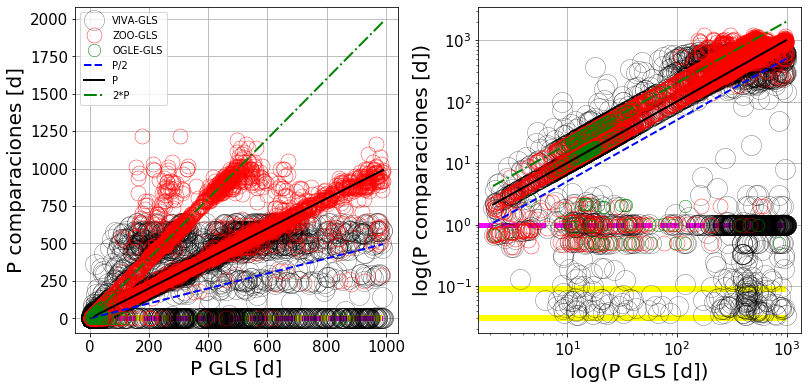

In [38]:
#Comparamos los periodos:

plt.figure(figsize=(13,6))

grid = plt.GridSpec(ncols=6, nrows=1, wspace=1.5, hspace=1.5)

plt.subplot(grid[0,:3])
plt.plot(df_GLS_VIVA['P'], df_GLS_VIVA['bestPeriod'],'k.', ms=40, mfc='none', mew=0.25, label='VIVA-GLS')
plt.plot(df_GLS_ZOO['P'],  df_GLS_ZOO['period'],'r.', ms=30, mfc='none', mew=0.4, label='ZOO-GLS')
plt.plot(df_GLS_OGLE['P'], df_GLS_OGLE['P_1'],'g.', ms=25, mfc='none', mew=0.5, label='OGLE-GLS')

xi = np.linspace(min(df_GLS_ZOO['P']), max(df_GLS_ZOO['P']), 100)    
plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
plt.plot(xi, xi, '-k', lw=lw, label='P')
plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')
    
    
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)
plt.xlabel('P GLS [d]'  ,fontsize=fz+5)
plt.ylabel('P comparaciones [d]',fontsize=fz+5)

#Franja amarilla
plt.hlines(y=0.03, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='yellow', linestyles='solid', lw=6)
plt.hlines(y=0.09, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='yellow', linestyles='solid', lw=6)

#Estructura de periodo = 1
plt.hlines(y=1, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='magenta', linestyles='--', lw=5)
plt.grid('on')
plt.legend(loc='best', fontsize=10)

#--------


plt.subplot(grid[0,3:])
plt.plot(df_GLS_VIVA['P'], df_GLS_VIVA['bestPeriod'],'k.', ms=40, mfc='none', mew=0.25, label='VIVA-GLS')
plt.plot(df_GLS_ZOO['P'],  df_GLS_ZOO['period'],'r.', ms=30, mfc='none', mew=0.4, label='ZOO-GLS')
plt.plot(df_GLS_OGLE['P'], df_GLS_OGLE['P_1'],'g.', ms=25, mfc='none', mew=0.5, label='OGLE-GLS')

xi = np.linspace(min(df_GLS_ZOO['P']), max(df_GLS_ZOO['P']), 100)    
plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
plt.plot(xi, xi, '-k', lw=lw, label='P')
plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')
    
    
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)
plt.xlabel('log(P GLS [d])'  ,fontsize=fz+5)
plt.ylabel('log(P comparaciones [d])',fontsize=fz+5)

#Franja amarilla
plt.hlines(y=0.03, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='yellow', linestyles='solid', lw=6)
plt.hlines(y=0.09, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='yellow', linestyles='solid', lw=6)

#Estructura de periodo = 1
plt.hlines(y=1, xmin=0, xmax=max(df_GLS_ZOO['P']), colors='magenta', linestyles='--', lw=5)

plt.xscale('log')
plt.yscale('log')
plt.grid('on')
plt.show()

He puesto ambos plots para claridad del análisis. En la comparación de periodos de la izquierda, podemos ver que la comparación ZOO-GLS tienen muchos periodos en común, como así fuentes ubicadas en el aliasing del doble del periodo. Es interante ver que a medida que el periodo crece, la dispersión en los periodos a lo largo de las regiones esperadas comienza a crecer. Supongo que esto puede ser un comportamiento normal en la determinación de periodos con métodos espectrales, donde periodos de, por ejemplo, 300 días y 315 días pueden ser considerados similares, dado que las series de tiempo no son uniformemente sampleadas. 


En el de la derecha, gracias a la escala logarítmica, se puede ver que las fuentes en común de GLS-OGLE también se ubican en la línea negra (mismo periodo) y en la linea verde (doble del periodo). Todo esperable hasta aquí. 

La comparación GLS-VIVA es visible en todos lados, la línea magenta del aliasing de 1 día está complétamente poblada.



En esta mísma lógica, haremos un crossmatch entre las comparaciones (ZOO-GLS) y (VIVA-GLS), para ver los periodos:

fuentes en común (GLS-ZOO) - (GLS-VIVA): 2673


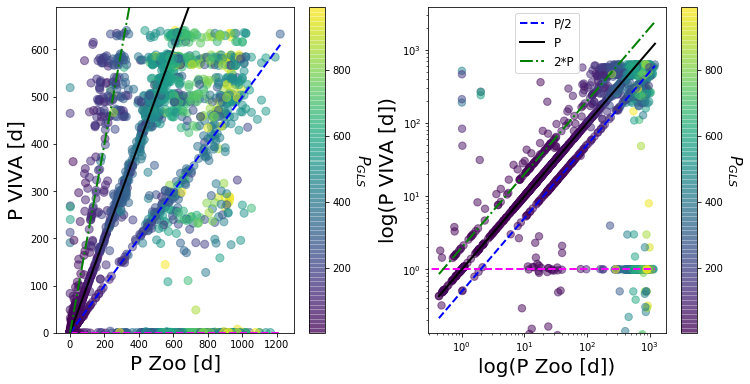

In [70]:
#!head ./Catalogos_locales/DobleMatch_GLSZOO_GLSVIVA.csv

df_comparison = pd.read_csv('./Catalogos_locales/DobleMatch_GLSZOO_GLSVIVA.csv', sep=',',skiprows=0)
print("fuentes en común (GLS-ZOO) - (GLS-VIVA):", len(df_comparison['Separation']))

plt.figure(figsize=(12,6))

grid = plt.GridSpec(ncols=6, nrows=1, wspace=1.5, hspace=1.5)

plt.subplot(grid[0,:3])
xi = np.linspace(min(df_comparison['period']), max(df_comparison['period']), 100)    
plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
plt.plot(xi, xi, '-k', lw=lw, label='P')
plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')

sc=plt.scatter(df_comparison['period'], df_comparison['bestPeriod'],c=df_comparison['P_1'], s=65, alpha=0.5)

#legend
cbar = plt.colorbar(sc)
cbar.set_label(r'${ P_{GLS}} }$', rotation=270, fontsize=16, labelpad=20)
plt.ylim(0,max(df_comparison['bestPeriod'])+50)
plt.hlines(y=1, xmin=0, xmax=max(df_comparison['period']), colors='magenta', linestyles='--', lw=2)
plt.xlabel('P Zoo [d]'  ,fontsize=fz+5)
plt.ylabel('P VIVA [d]',fontsize=fz+5)

#----

plt.subplot(grid[0,3:])
xi = np.linspace(min(df_comparison['period']), max(df_comparison['period']), 100)    
plt.plot(xi, xi/2., '--b', lw=lw, label='P/2')
plt.plot(xi, xi, '-k', lw=lw, label='P')
plt.plot(xi, 2.*xi, '-.g', lw=lw, label='2*P')

sc=plt.scatter(df_comparison['period'], df_comparison['bestPeriod'],c=df_comparison['P_1'], s=55, alpha=0.5)

#legend
cbar = plt.colorbar(sc)
cbar.set_label(r'${ P_{GLS}} }$', rotation=270, fontsize=16, labelpad=20)

#plt.ylim(0,max(df_comparison['bestPeriod'])+50)
plt.hlines(y=1, xmin=0, xmax=max(df_comparison['period']), colors='magenta', linestyles='--', lw=2)
plt.legend(loc='best', fontsize=12)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('log(P Zoo [d])'  ,fontsize=fz+5)
plt.ylabel('log(P VIVA [d])',fontsize=fz+5)

plt.show()

Podemos ver que las fuentes se posicionan a lo largo, y entre medio (en general) de los aliasings más probables. Además, la barra de colores a la derecha también posiciona el periodo que yo he entronado con el periodograma GLS, por lo que finalmente se puede concluir que, en general, las 3 bases de datos están de acuerdo en los periodos que han sido calculados por lo menos para periodos grandes (facilmente visto para P>100 días). 

Hasta acá el trabajo del lunes 18 de Mayo :)

## Lunes 31 de Mayo

Trabajo hecho en recolectar series de tiempo de las fuentes clasificadas en OGLE para obtener las características (features). Pero el trabajo está inconcluso y sin poder ser visualizado aún.

## Lunes 7 de Junio

Juntaremos los catálogos para tener el porcentaje de clasificación y el periodo en un solo catálogo, para luego así comparar el porcentaje de clasificación de la encuesta Variable star Zoo, y la clasificación de OGLE.

In [113]:
!ls Catalogos_locales/

CatalogoCompleto_23Marzo2021.csv        list_Zoo_Class_2Junio2021.csv
CatalogoIncompleto_23Marzo2021.cat      match_OGLE_GLS.csv
Catalogos_zoo_cruzados.csv              match_VIVA_GLS.csv
DobleMatch_GLSZOO_GLSVIVA.csv           match_VIVA_OGLE.csv
OGLE_IV_BULGE.txt                       match_VIVA_ZOO.csv
OGLE_IV_BULGE_Modificado15Abril2021.txt match_ZOO_GLS.csv
VIVA_Ra_entre_259Y270_modificado.csv    match_Zoo_OGLE.csv
crossmatch_ZooCompleto_OGLE.csv         periods_coord_IDs.csv


In [245]:
#Datos Ciudadanos:
#ID          RA        Dec      period
df_Zoo_Class = pd.read_csv('./Catalogos_locales/list_Zoo_Class_2Junio2021.csv', sep=',')

#ID          RA        Dec      period
df_Zoo = pd.read_csv('./Catalogos_locales/periods_coord_IDs.csv', sep=',')

Primero, juntamos ambos catálogos usando los IDs. Fue hecho "a la fuerza", modificando y comparando los nombres para construir el catálogo a utilizar. El método sigue y está muy poco optimizado, para los más de 50 mil fuentes, demoró casí 18 horas en construir el catálogo:

In [ ]:
#Creamos un catálogo cruzando toda la información:

Catalogo = open('Catalogos_locales/Catalogos_zoo_cruzados.csv','w')
#Definimos las 12 columnas:
Catalogo.write('#ID\tRA\tDec\tPeriod\tfilename\tNclassifications\tMira\tRRLyr-Ceph\tnoise\tmicrolensing\tbinary\tunusual\n')


largo_zoo_class   = len(df_Zoo_Class['filename'])
largo_zoo_periods = len(df_Zoo['ID'])


for i in range(largo_zoo_class):
    #Elegimos el nombre ID del catálogo 
    nombre = df_Zoo_Class['filename'][i]
    nombre = nombre.split('.')[0]

    #Vamos a hacer coincidir los nombres con el otro catálogo:
    for j in range(largo_zoo_periods):
        ID = df_Zoo['ID'][j]
        
        #Si los IDs coinciden, se guardan en el catálogo:
        if nombre == ID:
            print(nombre, ID)

            #creamos un array auxiliar para almacenar la informacion requerida:            
            a = df_Zoo.values[j], df_Zoo_Class.values[i]
            
            Catalogo.write("%s\t%0.7f\t%0.7f\t%0.4f\t%s\t%i\t%.1f\t%.1f\t%.1f\t%.1f\t%.1f\t%.1f\n" \
                          %(a[0][0],a[0][1],a[0][2],a[0][3],a[1][0],a[1][1],a[1][2],a[1][3],a[1][4], \
                            a[1][5],a[1][6],a[1][7]))
            
    Catalogo.flush()
Catalogo.close()

Con el catálogo construido, procederemos a visualizar el porcentaje de clasificación, contrastando con las categorías principales del catálogo de OGLE. La forma que escogí para visualizar los datos es a través de un mapa de calor, con los que se suele representar las matrices de confusión para cuantificar el desempeño de algoritmos de clasificación; donde en el eje x señalará la clasificación dada por la encuesta Variable star zoo, y en el eje y se señala la clase dada por OGLE.

En el centro de cada caja, se señala EL PROMEDIO del porcentaje de cada clase dador por la encuesta. El promedio ha sido elegido como primera aproximación para visualizar los datos. En el futuro se podrá elegir un estadistico más adecuado (o ad-hoc) que pueda representar de forma fidedigna la información que contiene la encuesta Variable Star Zoo. Además, me parece pertinente cuantificar la incerteza sobre este estadistico usando algún método de sampleo consagrado, como Jackknife o Bootstrap.

Allá vamos:

In [256]:
ZooCompleto_OGLE = pd.read_csv('./Catalogos_locales/crossmatch_ZooCompleto_OGLE.csv', sep=',')

print(np.unique(ZooCompleto_OGLE['Type']))

print("Largo de la muestra:", len(ZooCompleto_OGLE['Type']))

['Cep' 'ECL' 'RRLyr' 'T2Cep']
Largo de la muestra: 9769


In [233]:
#Primero, visualizamos qué hay:
#Hacemos un array con los diferentes tipos de clasificacion
lista_clases = np.unique(ZooCompleto_OGLE['Type'])
clases = ZooCompleto_OGLE['Type']

#creamos un array para poder guardar la información:
matriz_heatmap = np.zeros((4, 6))

contador = 0

for grupos in lista_clases:
    print(grupos)
    print(contador)
    
    array_Mira = []
    array_RRlyrae_Ceph = []
    array_noise = []
    array_micro = []
    array_binary = []
    array_unusual = []
    
    clase = np.where(clases == grupos)
    
    for j in clase:  
        
        #Usando la misma estructura anterior, calculamos algunos estadísticos para visualizar el heatmap:

        array_Mira.append(ZooCompleto_OGLE['Mira'][j])
        array_RRlyrae_Ceph.append(ZooCompleto_OGLE['RRLyr-Ceph'][j])
        array_noise.append(ZooCompleto_OGLE['noise'][j])
        array_micro.append(ZooCompleto_OGLE['microlensing'][j])
        array_binary.append(ZooCompleto_OGLE['binary'][j])
        array_unusual.append(ZooCompleto_OGLE['unusual'][j])

    matriz_heatmap[contador] = [np.mean(array_Mira), np.mean(array_RRlyrae_Ceph), np.mean(array_noise),\
              np.mean(array_micro), np.mean(array_binary), np.mean(array_unusual)]

    contador += 1 
print(matriz_heatmap)

Cep
0
ECL
1
RRLyr
2
T2Cep
3
[[ 6.35882353 84.22941176  3.53529412  0.39411765  3.14117647  2.35882353]
 [ 5.0518996  39.7478398   6.13280757  0.57739679 46.47085448  2.03578384]
 [ 3.68460169 79.69577214  4.78206498  0.45349355  6.63204272  4.77076101]
 [12.41121495 71.77149533  3.59392523  0.31682243  9.16682243  2.75280374]]


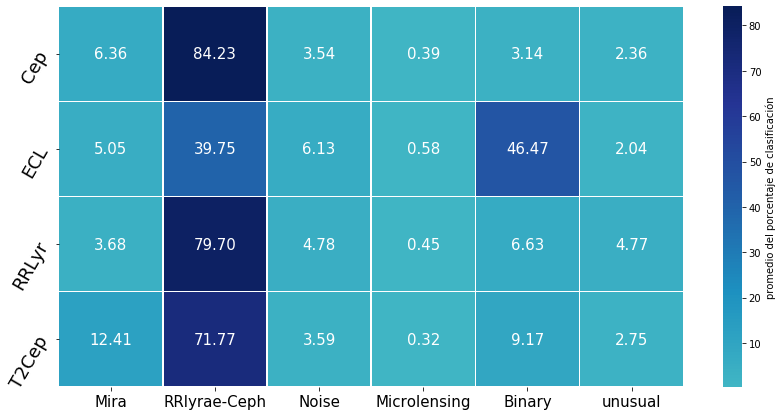

In [255]:
df = pd.DataFrame(matriz_heatmap, columns=["Mira","RRlyrae-Ceph","Noise","Microlensing","Binary","unusual" ])

plt.figure(figsize=(14,7))
heat_map=sb.heatmap(df,cmap='YlGnBu',center=0,annot=True,fmt="0.2f",linewidths=.5,annot_kws={"fontsize":15},cbar_kws={'label': 'promedio del porcentaje de clasificación'})
plt.yticks([0.5,1.5,2.5,3.5],["Cep", "ECL", "RRLyr", "T2Cep"], fontsize=18, rotation=60)
plt.xticks(fontsize=15)
plt.ylim(4,0)
plt.show()

Usando como primera aproximación el promedio de los porcentajes de clasificación, podemos ver que la clase "RRLyrae-Ceph" concentra el mayor porcentaje de clasificación entre las categorías de OGLE. Ésto no sorprende ya que en estas cuatro categorías principales con excepción de las binarias (ECL) todas son estrellas pulsantes  y relacionadas a las Cepheidas y RRLyraes. 

En el caso de las estrellas binarias, la confusión entre las clases (RRLyrae-Ceph / ECL) es importante, ascendiendo al 39.7% en promedio, lo que también es esperable dada las diferentes formas que presentan las estrellas binarias en su curva de luz. Aún así, la correcta clasificación de las estrellas (Binarias / ECL) también asciende a un número elevado (46,7%).

Dos últimos comentarios: 

1. El porcentaje (en promedio) más grande que observo entre clases no relacionadas es entre las clases (T2Cep / Mira), con 12.4% en promedio. Asumo que podría deberser a la naturaleza de pulsación sinusoidal de estos tipos estelares.
2. Todas los demás porcentajes entre clases no relacionadas no superan el 10% en promedio, por lo que esta primera aproximación, con más de 9 mil fuentes en total, parece prometedora :)

La próxima semana tengo dos presentaciones, por lo que el siguiente lunes 14 de Junio no pondré mucha atención en esto, pero pensaré en cómo agregar las condiciones de las que me hablaste en el último correo.